Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Calculating silhouette scores for different cluster counts:
Silhouette Score for k=3: 0.5162
Silhouette Score for k=4: 0.4737
Silhouette Score for k=5: 0.4440
Silhouette Score for k=6: 0.4325
Silhouette Score for k=7: 0.3854

Optimal number of clusters: 3
Highest Silhouette Score: 0.5162
Cluster summary saved to 'cluster_summary.xlsx'.


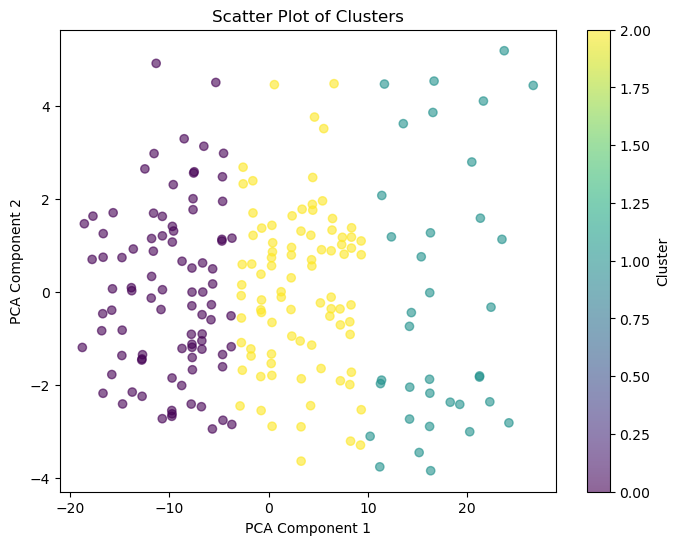

In [66]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Functions

def load_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()
    return df

def ensure_column_exists(df, column_name, alternative_names=None):
    if column_name in df.columns:
        return column_name
    elif alternative_names:
        for alt_name in alternative_names:
            if alt_name in df.columns:
                return alt_name
    raise ValueError(f"Column '{column_name}' or alternatives {alternative_names} not found.")

def create_financial_features(df):
    current_year = datetime.now().year

    df['Debt_to_Income_Ratio'] = df['Outstanding Principal'] / df['Qualified / Verified\nIncome']
    df['Remaining_Loan_Percentage'] = df['Outstanding Balance'] / df['Loan Amount']
    df['Loan_to_Income_Ratio'] = df['Loan Amount'] / df['Qualified / Verified\nIncome']
    df['Monthly_Repayment_Burden'] = df['Outstanding Balance'] / df['Loan Term (Months)']
    df['Consistency_Score'] = df['Average activities per day'] / df['Average total activities per month']

    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
    df['Age'] = current_year - df['Date of Birth'].dt.year

    df['Disbursement Date'] = pd.to_datetime(df['Disbursement Date'], errors='coerce')
    df['Elapsed_Months'] = (datetime.now() - df['Disbursement Date']).dt.days // 30
    df['Remaining_Tenure'] = df['Loan Term (Months)'] - df['Elapsed_Months']

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

def preprocess_data(df, total_activities_col, columns_to_remove):
    df['ID'] = df['ID'].astype(str)
    df_original = df.copy()

    # Remove unnecessary columns (if they exist)
    existing_columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    df = df.drop(columns=existing_columns_to_remove)

    # Drop columns with more than 50% missing data
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)

    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')

    if not numeric_cols.empty:
        df[numeric_cols] = pd.DataFrame(
            imputer_num.fit_transform(df[numeric_cols]),
            columns=numeric_cols,
            index=df.index
        )
    
    if not categorical_cols.empty:
        df[categorical_cols] = pd.DataFrame(
            imputer_cat.fit_transform(df[categorical_cols]),
            columns=categorical_cols,
            index=df.index
        )

    # Encode categorical columns if needed
    if 'Loan Status' in df.columns:
        df = pd.get_dummies(df, columns=['Loan Status'], drop_first=False)

    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'MALE': 0, 'FEMALE': 1})

    categorical_columns_to_encode = ['Province', 'Residential Status']
    columns_to_encode = [col for col in categorical_columns_to_encode if col in df.columns]
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

    # Scale the features
    scaler = StandardScaler()
    df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))

    return df, df_original

def perform_pca(df_encoded, variance_threshold=0.9):
    pca = PCA(n_components=variance_threshold, random_state=42)
    df_pca = pd.DataFrame(pca.fit_transform(df_encoded))
    return df_pca

def determine_optimal_clusters(df_pca, k_range=range(4, 8)):
    """
    Determine the optimal number of clusters using the silhouette score.
    """
    silhouette_scores = []
    
    print("Calculating silhouette scores for different cluster counts:")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(df_pca)
        silhouette_avg = silhouette_score(df_pca, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")
    
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\nOptimal number of clusters: {optimal_k}")
    print(f"Highest Silhouette Score: {max(silhouette_scores):.4f}")
    
    return optimal_k

def perform_clustering(df_pca, df_original, optimal_k):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
    df_original['Cluster'] = kmeans.fit_predict(df_pca)
    return df_original

def plot_clusters(df_pca, df_original):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_original['Cluster'], cmap='viridis', alpha=0.6)
    plt.title('Scatter Plot of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Main Execution

file_path = 'Data 3 - October, 2024.xlsx'
sheet_name = 'Parachute - Cross Section'

# Load and preprocess data
df = load_data(file_path, sheet_name)
total_activities_col = ensure_column_exists(df, 'Total Activities', alternative_names=['Total Activies '])
df = create_financial_features(df)

columns_to_remove = ['Disbursement Date', 'Date of Birth', 'ID', 'Gender',
                     'Loan Amount', 'Outstanding Balance', 'Outstanding Principal', 
                     'Loan Term (Months)', 'Stated Income on application', 
                     'Inspiration Count', 'Average total activities per month', 
                     'Average activities per day']

df_encoded, df_original = preprocess_data(df, total_activities_col, columns_to_remove)

# PCA and clustering
df_pca = perform_pca(df_encoded)
optimal_k = determine_optimal_clusters(df_pca, k_range=range(3, 8))
df_clustered = perform_clustering(df_pca, df_original, optimal_k)
df_clustered.to_excel("output/df_clustered.xlsx")
# Export cluster summary
numeric_cols = df_clustered.select_dtypes(include=['number']).columns
cluster_summary = df_clustered[numeric_cols].groupby('Cluster').mean()
cluster_summary.to_excel("output/cluster_summary.xlsx")
print("Cluster summary saved to 'cluster_summary.xlsx'.")

# Visualize clusters
plot_clusters(df_pca, df_clustered)

In [70]:
import pandas as pd
import numpy as np
import os

# Load data
trans_union_path = 'Data 3 - October, 2024.xlsx'  # Replace with the correct path
trans_union_data = pd.read_excel(trans_union_path, sheet_name='TU - Panel')

# Ensure consistent data types for merging
df_clustered['ID'] = df_clustered['ID'].astype(str)  # Convert ID to string in df_clustered
trans_union_data['loan_id'] = trans_union_data['loan_id'].astype(str)  # Convert loan_ID to string in TransUnion data

# Perform the merge
merged_data = pd.merge(df_clustered, trans_union_data, left_on='ID', right_on='loan_id', how='left')

# Proceed with Feature Engineering
merged_data['Total_Debt'] = (
    merged_data['revolving_credit_balance'] + merged_data['instalment_credit_balance']
)
merged_data['Total_Credit_Limit'] = (
    merged_data['revolving_credit_limit'] + merged_data['instalment_credit_limit']
)
merged_data['Debt_to_Credit_Ratio'] = merged_data['Total_Debt'] / merged_data['Total_Credit_Limit']
merged_data['Revolving_Utilization'] = (
    merged_data['revolving_credit_balance'] / merged_data['revolving_credit_limit']
)
merged_data['Installment_Utilization'] = (
    merged_data['instalment_credit_balance'] / merged_data['instalment_credit_limit']
)

# Fill missing values and handle divide-by-zero cases
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.fillna(0, inplace=True)

# Step 1: Derive Engagement_Level
median_consistency = merged_data['Consistency_Score'].median()  # Compute median of Consistency_Score
merged_data['Engagement_Level'] = (merged_data['Consistency_Score'] >= median_consistency).astype(int)

# Step 2: Derive Repayment_Risk
# Customers are at risk if they have high Debt-to-Credit Ratio or past dues
merged_data['Repayment_Risk'] = (
    (merged_data['Debt_to_Credit_Ratio'] > 0.8) | 
    (merged_data['revolving_credit_past_due'] > 0) | 
    (merged_data['instalment_credit_past_due'] > 0)
).astype(int)

# Additional Features for Engagement Prediction
merged_data['Activity_Diversity'] = (
    (merged_data['Quiz Count'] > 0).astype(int) +
    (merged_data['Mood Count'] > 0).astype(int) +
    (merged_data['Inspiration Count'] > 0).astype(int)
)
merged_data['Engagement_Regularity'] = (
    merged_data['Consistency_Score'] * merged_data['Average activities per day']
)
merged_data['Missed_Periods'] = (
    merged_data['Elapsed_Months'] - (merged_data['Total Activities'] / merged_data['Average total activities per month'])
)
merged_data['Engagement_to_Income_Ratio'] = (
    merged_data['Total Activities'] / merged_data['Qualified / Verified\nIncome']
)

# Save the merged dataset
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
merged_output_path = os.path.join(output_dir, 'merged_clustered_transunion_data_fixed_with_risks.xlsx')
merged_data.to_excel(merged_output_path, index=False)
print(f"Merged dataset with Engagement_Level and Repayment_Risk saved to '{merged_output_path}'.")

# Model 1: Engagement Prediction
engagement_features = [
    'Consistency_Score', 'Quiz Count', 'Mood Count', 'Inspiration Count',
    'Total Activities', 'Average total activities per month', 'Average activities per day',
    'Activity_Diversity', 'Engagement_Regularity', 'Missed_Periods',
    'Engagement_to_Income_Ratio', 'fico_score', 'Revolving_Utilization',
    'Installment_Utilization', 'Debt_to_Credit_Ratio'
]
engagement_data = merged_data[engagement_features + ['Engagement_Level']]

# Model 2: Loan Repayment Risk Prediction
repayment_features = [
    'Debt_to_Credit_Ratio', 'Revolving_Utilization', 'Installment_Utilization',
    'Total_Debt', 'Total_Credit_Limit', 'fico_score', 'count_of_inquiries',
    'revolving_credit_past_due', 'instalment_credit_past_due', 'open_credit_past_due'
]
repayment_data = merged_data[repayment_features + ['Repayment_Risk']]

# Save datasets for further processing
engagement_output_path = os.path.join(output_dir, 'engagement_model_data_with_additional_features.xlsx')
repayment_output_path = os.path.join(output_dir, 'repayment_model_data.xlsx')
engagement_data.to_excel(engagement_output_path, index=False)
repayment_data.to_excel(repayment_output_path, index=False)

print(f"Engagement Model Data (with additional features) saved to '{engagement_output_path}'.")
print(f"Repayment Model Data saved to '{repayment_output_path}'.")

Merged dataset with Engagement_Level and Repayment_Risk saved to 'output/merged_clustered_transunion_data_fixed_with_risks.xlsx'.
Engagement Model Data (with additional features) saved to 'output/engagement_model_data_with_additional_features.xlsx'.
Repayment Model Data saved to 'output/repayment_model_data.xlsx'.



Performing Recursive Feature Elimination with Random Forest...

Random Forest Report (RFE Selected Features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       246

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487

AUC (Random Forest): 1.00

Performing Recursive Feature Elimination with XGBoost...

XGBoost Report (RFE Selected Features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       246

    accuracy                           1.00       487
   macro avg       1.00      1.00      1.00       487
weighted avg       1.00      1.00      1.00       487

AUC (XGBoost): 1.00

Training Logistic Regression...

Logistic Regression Report:
              precision    r

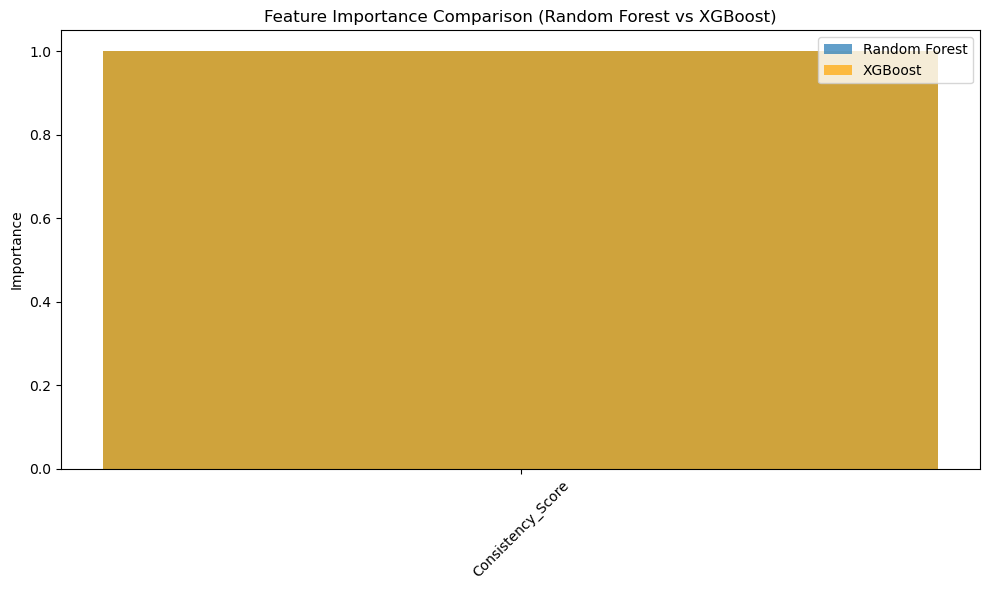

In [75]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load engagement data
engagement_data = pd.read_excel('output/engagement_model_data_with_additional_features.xlsx')

# Define features and target
X_eng = engagement_data.drop(columns=['Engagement_Level'])
y_eng = engagement_data['Engagement_Level']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_eng, y_eng, test_size=0.4, random_state=42, stratify=y_eng
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Handle missing values
X_train.fillna(X_train.median(), inplace=True)
X_val.fillna(X_val.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

# Feature Engineering: Add interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_inter = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
X_val_inter = pd.DataFrame(poly.transform(X_val), columns=poly.get_feature_names_out(X_train.columns))
X_test_inter = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))

# Random Forest with Recursive Feature Elimination
print("\nPerforming Recursive Feature Elimination with Random Forest...")
rf = RandomForestClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1, n_estimators=50, random_state=42)
rf_rfe = RFECV(estimator=rf, step=1, cv=5, scoring='roc_auc')
rf_rfe.fit(X_train_inter, y_train)

selected_features_rf = X_train_inter.columns[rf_rfe.support_]
X_train_rf = X_train_inter[selected_features_rf]
X_val_rf = X_val_inter[selected_features_rf]
X_test_rf = X_test_inter[selected_features_rf]

# Train Random Forest on selected features
rf.fit(X_train_rf, y_train)
y_pred_rf = rf.predict(X_test_rf)
auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test_rf)[:, 1])
print("\nRandom Forest Report (RFE Selected Features):")
print(classification_report(y_test, y_pred_rf))
print(f"AUC (Random Forest): {auc_rf:.2f}")

# XGBoost with RFE
print("\nPerforming Recursive Feature Elimination with XGBoost...")
xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=0.5, random_state=42, eval_metric='logloss')
xgb_rfe = RFECV(estimator=xgb, step=1, cv=5, scoring='roc_auc')
xgb_rfe.fit(X_train_inter, y_train)

selected_features_xgb = X_train_inter.columns[xgb_rfe.support_]
X_train_xgb = X_train_inter[selected_features_xgb]
X_val_xgb = X_val_inter[selected_features_xgb]
X_test_xgb = X_test_inter[selected_features_xgb]

# Train XGBoost on selected features
xgb.fit(X_train_xgb, y_train)
y_pred_xgb = xgb.predict(X_test_xgb)
auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test_xgb)[:, 1])
print("\nXGBoost Report (RFE Selected Features):")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC (XGBoost): {auc_xgb:.2f}")

# Logistic Regression for comparison
print("\nTraining Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_rf, y_train)
y_pred_lr = lr.predict(X_test_rf)
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test_rf)[:, 1])
print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print(f"AUC (Logistic Regression): {auc_lr:.2f}")

# Ensemble Model with weighted voting
print("\nTraining Ensemble Model...")
ensemble_weights = [auc_rf, auc_xgb, auc_lr]  # Use AUC scores for weighting

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)],
    voting='soft',
    weights=ensemble_weights
)
ensemble.fit(X_train_rf, y_train)
y_pred_ensemble = ensemble.predict(X_test_rf)
auc_ensemble = roc_auc_score(y_test, ensemble.predict_proba(X_test_rf)[:, 1])
print("\nEnsemble Model Report:")
print(classification_report(y_test, y_pred_ensemble))
print(f"AUC (Ensemble Model): {auc_ensemble:.2f}")

# Plot Feature Importance Comparison
plt.figure(figsize=(10, 6))
plt.bar(selected_features_rf, rf.feature_importances_, label="Random Forest", alpha=0.7)
plt.bar(selected_features_xgb, xgb.feature_importances_, label="XGBoost", alpha=0.7, color="orange")
plt.title("Feature Importance Comparison (Random Forest vs XGBoost)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()